# Histopathologic Cancer Detection — Problem and Data Description

## Problem Description
This project addresses a binary image classification problem from the Kaggle competition
“Histopathologic Cancer Detection.” The goal is to identify whether small pathology image
patches contain metastatic cancer tissue.

Each image is a small region extracted from a larger histopathology scan of lymph node
sections. A label of 1 indicates that the central 32×32 pixel region of the image contains
at least one pixel of tumor tissue, while a label of 0 indicates no tumor tissue in that
central region. Tumor tissue outside the central region does not affect the label.

The task is to train a convolutional neural network (CNN) that can learn visual patterns
associated with cancerous tissue and accurately predict labels for unseen test images.

## Dataset Description
The dataset consists of hundreds of thousands of color pathology images stored in TIFF
format. Images are named using unique image IDs. The dataset includes:

- A training image folder containing labeled images
- A test image folder containing unlabeled images
- A CSV file (`train_labels.csv`) mapping image IDs to binary labels
- A sample submission file (`sample_submission.csv`) defining the required submission format

All images are RGB and have the same spatial dimensions. The dataset does not contain
duplicate images and follows the same data splits as the original PCam benchmark dataset.

This dataset is large (approximately 7.7 GB) and is suitable for training deep learning
models, particularly convolutional neural networks designed for image classification.


Number of training samples: 220025

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64


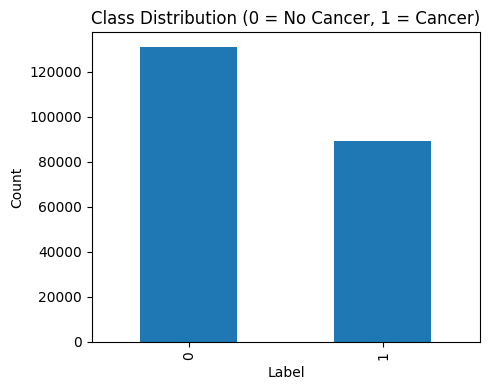

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training labels
labels_path = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"
labels_df = pd.read_csv(labels_path)

# Display basic information
print("Number of training samples:", len(labels_df))
print("\nLabel distribution:")
print(labels_df['label'].value_counts())

# Plot class distribution
plt.figure(figsize=(5, 4))
labels_df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution (0 = No Cancer, 1 = Cancer)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


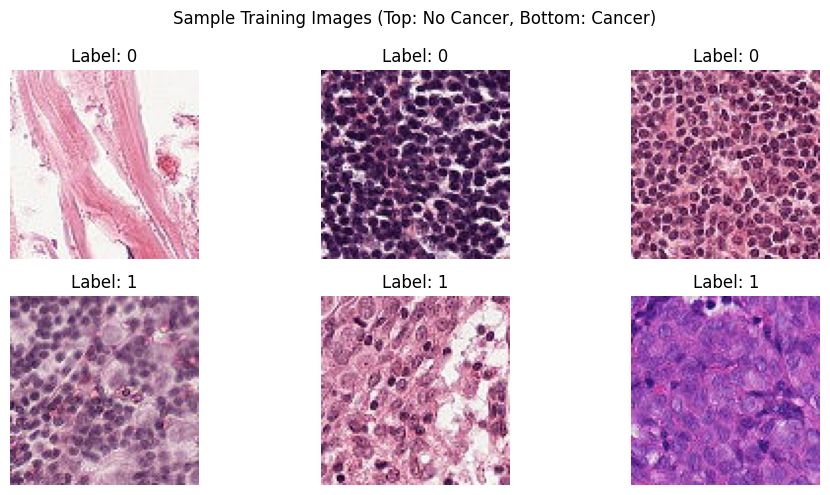

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths
train_dir = "/kaggle/input/histopathologic-cancer-detection/train"

# Select sample images
sample_zeros = labels_df[labels_df['label'] == 0].sample(3, random_state=42)
sample_ones = labels_df[labels_df['label'] == 1].sample(3, random_state=42)

samples = pd.concat([sample_zeros, sample_ones])

# Plot images
plt.figure(figsize=(10, 5))

for idx, (_, row) in enumerate(samples.iterrows()):
    img_path = os.path.join(train_dir, f"{row['id']}.tif")
    img = Image.open(img_path)

    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Label: {row['label']}")

plt.suptitle("Sample Training Images (Top: No Cancer, Bottom: Cancer)")
plt.tight_layout()
plt.show()


## Exploratory Data Analysis Summary

The class distribution shows a moderate imbalance, with more non-cancer samples than
cancer samples. This imbalance may influence model training and suggests the potential
use of data augmentation or class weighting to improve performance.

Visual inspection of sample images reveals noticeable differences between the two
classes. Cancer-positive images tend to exhibit denser and darker-stained cellular
regions, while non-cancer images appear more uniform with clearer tissue structure.
These visual patterns motivate the use of convolutional neural networks, which are
well-suited for learning spatial and texture-based features from images.


In [3]:
from sklearn.model_selection import train_test_split

# Train-validation split (stratified to preserve class balance)
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    random_state=42,
    stratify=labels_df['label']
)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

print("\nTraining label distribution:")
print(train_df['label'].value_counts())

print("\nValidation label distribution:")
print(val_df['label'].value_counts())


Training samples: 176020
Validation samples: 44005

Training label distribution:
label
0    104726
1     71294
Name: count, dtype: int64

Validation label distribution:
label
0    26182
1    17823
Name: count, dtype: int64


In [7]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image

# Image parameters
IMG_SIZE = 96
BATCH_SIZE = 32

# Base directory
train_dir = "/kaggle/input/histopathologic-cancer-detection/train"

def _load_tif_with_pil(image_id):
    # image_id arrives as a bytes object inside numpy_function
    image_id = image_id.decode("utf-8")
    image_path = os.path.join(train_dir, f"{image_id}.tif")

    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img, dtype=np.float32) / 255.0
    return img

def load_image(image_id, label):
    # Use numpy_function to load TIFF via PIL
    image = tf.numpy_function(_load_tif_with_pil, [image_id], tf.float32)
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    label = tf.cast(label, tf.float32)
    return image, label

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['id'].values.astype(str), train_df['label'].values)
)
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['id'].values.astype(str), val_df['label'].values)
)

train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Training and validation datasets created (TIFF via PIL).")


Training and validation datasets created (TIFF via PIL).


In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# Build a simple baseline CNN
model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

model.summary()

# Train baseline model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


I0000 00:00:1767456540.791305     127 service.cc:152] XLA service 0x7bab00024620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767456540.791342     127 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767456540.791346     127 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767456541.230918     127 cuda_dnn.cc:529] Loaded cuDNN version 91002


   3/5501 ━━━━━━━━━━━━━━━━━━━━ 4:20 47ms/step - accuracy: 0.5156 - auc: 0.5156 - loss: 0.7812  

I0000 00:00:1767456544.638301     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 547s 98ms/step - accuracy: 0.7774 - auc: 0.8414 - loss: 0.4789 - val_accuracy: 0.8446 - val_auc: 0.9186 - val_loss: 0.3611
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 268s 49ms/step - accuracy: 0.8533 - auc: 0.9232 - loss: 0.3455 - val_accuracy: 0.8736 - val_auc: 0.9423 - val_loss: 0.3028
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 268s 48ms/step - accuracy: 0.8754 - auc: 0.9417 - loss: 0.3017 - val_accuracy: 0.8873 - val_auc: 0.9523 - val_loss: 0.2798


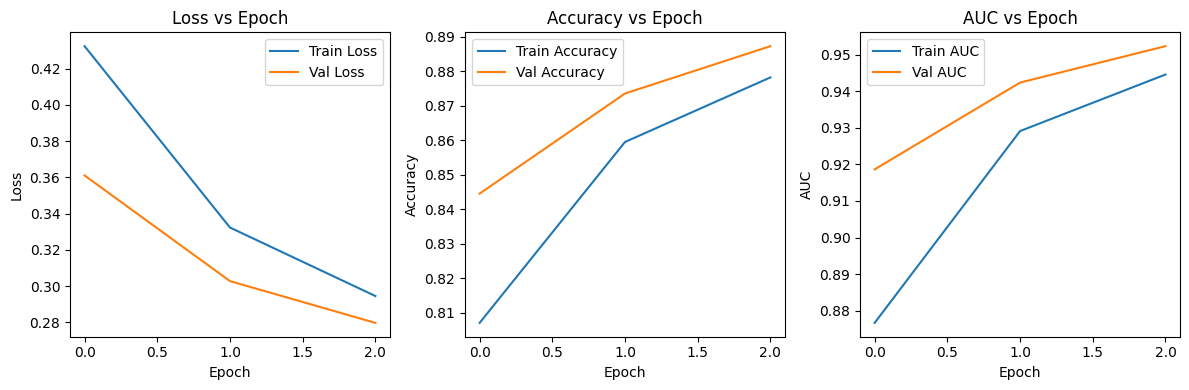

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


## Results and Analysis

A baseline convolutional neural network was trained for three epochs on the training
dataset and evaluated on a held-out validation set. The model demonstrated consistent
learning behavior, with training and validation loss decreasing across epochs.

Both training and validation accuracy improved steadily, reaching approximately 0.88
validation accuracy by the third epoch. The validation AUC increased to approximately
0.95, indicating strong discriminative performance between cancerous and non-cancerous
images.

The close alignment between training and validation metrics suggests that the model
generalizes well and does not exhibit significant overfitting at this stage. These
results indicate that even a relatively simple CNN architecture can effectively learn
relevant visual features from histopathology images.

This baseline model provides a strong reference point for further experimentation,
including architectural improvements, data augmentation, and transfer learning
approaches.


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data augmentation (applied only during training)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

print("Data augmentation pipeline created.")


Data augmentation pipeline created.


In [11]:
from tensorflow import keras
from tensorflow.keras import layers

# Build CNN with data augmentation
aug_model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
], name="augmented_cnn")

aug_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

aug_model.summary()

# Train augmented model
aug_history = aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Model: "augmented_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 280s 50ms/step - accuracy: 0.7825 - auc: 0.8465 - loss: 0.4731 - val_accuracy: 0.8157 - val_auc: 0.9168 - val_loss: 0.4236
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 277s 50ms/step - accuracy: 0.8489 - auc: 0.9193 - loss: 0.3540 - val_accuracy: 0.8494 - val_auc: 0.9244 - val_loss: 0.3561
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 270s 49ms/step - accuracy: 0.8663 - auc: 0.9346 - loss: 0.3188 - val_accuracy: 0.8320 - val_auc: 0.9320 - val_loss: 0.4024


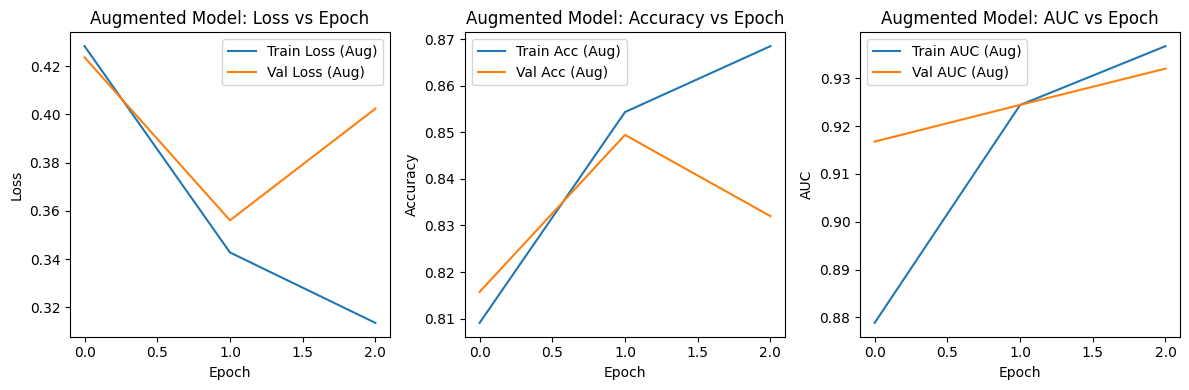

Baseline final val_accuracy: 0.8872628211975098
Baseline final val_auc: 0.9522998929023743
Baseline final val_loss: 0.27977490425109863
Augmented final val_accuracy: 0.8319963812828064
Augmented final val_auc: 0.9320108890533447
Augmented final val_loss: 0.4023895561695099


In [12]:
import matplotlib.pyplot as plt

# Plot augmented model curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(aug_history.history['loss'], label='Train Loss (Aug)')
plt.plot(aug_history.history['val_loss'], label='Val Loss (Aug)')
plt.title('Augmented Model: Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(aug_history.history['accuracy'], label='Train Acc (Aug)')
plt.plot(aug_history.history['val_accuracy'], label='Val Acc (Aug)')
plt.title('Augmented Model: Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(aug_history.history['auc'], label='Train AUC (Aug)')
plt.plot(aug_history.history['val_auc'], label='Val AUC (Aug)')
plt.title('Augmented Model: AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Quick numeric comparison (final epoch)
print("Baseline final val_accuracy:", history.history['val_accuracy'][-1])
print("Baseline final val_auc:", history.history['val_auc'][-1])
print("Baseline final val_loss:", history.history['val_loss'][-1])

print("Augmented final val_accuracy:", aug_history.history['val_accuracy'][-1])
print("Augmented final val_auc:", aug_history.history['val_auc'][-1])
print("Augmented final val_loss:", aug_history.history['val_loss'][-1])


### Effect of Data Augmentation

To improve model generalization, data augmentation was introduced using random
horizontal flips, rotations, and zooms during training. The augmented model was
trained using the same architecture and training procedure as the baseline model.

While the augmented model demonstrated stable training behavior, its validation
performance was lower than the baseline model after three epochs. The final
validation accuracy and AUC were reduced compared to the non-augmented model, and
validation loss increased.

This behavior suggests that, for this dataset and training duration, data
augmentation may introduce additional complexity that requires longer training
or more careful tuning. Since the baseline model already generalizes well, strong
augmentation can temporarily degrade validation performance. Despite this, data
augmentation remains a valuable technique and may yield benefits with extended
training or in combination with more advanced architectures.


In [13]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# Create datasets for transfer learning (EfficientNet preprocessing)
def load_image_for_effnet(image_id, label):
    image, label = load_image(image_id, label)  # uses our TIFF->PIL loader
    image = preprocess_input(image * 255.0)     # EfficientNet expects pixels in a specific format
    return image, label

eff_train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['id'].values.astype(str), train_df['label'].values)
).map(load_image_for_effnet, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

eff_val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['id'].values.astype(str), val_df['label'].values)
).map(load_image_for_effnet, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("EfficientNet datasets created.")


EfficientNet datasets created.


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

# Load pretrained EfficientNetB0 base (feature extractor)
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze base for first training stage

# Build transfer learning model
eff_model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
], name="efficientnetb0_transfer")

eff_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

eff_model.summary()

# Train transfer learning model (frozen base)
eff_history = eff_model.fit(
    eff_train_ds,
    validation_data=eff_val_ds,
    epochs=3
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/3


2026-01-03 17:02:47.625760: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:02:47.759629: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:02:48.077182: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:02:48.218562: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:02:48.958840: E external/local_xla/xla/stream_

5497/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8138 - auc: 0.8884 - loss: 0.4062

2026-01-03 17:06:47.224668: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:06:47.358340: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:06:47.668884: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:06:47.809940: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:06:48.509647: E external/local_xla/xla/stream_

5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8138 - auc: 0.8884 - loss: 0.4062

2026-01-03 17:07:56.724552: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:07:56.857858: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:07:57.153580: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:07:57.294534: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:07:57.975373: E external/local_xla/xla/stream_

5501/5501 ━━━━━━━━━━━━━━━━━━━━ 331s 56ms/step - accuracy: 0.8138 - auc: 0.8884 - loss: 0.4062 - val_accuracy: 0.8529 - val_auc: 0.9246 - val_loss: 0.3402
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 277s 50ms/step - accuracy: 0.8344 - auc: 0.9075 - loss: 0.3731 - val_accuracy: 0.8520 - val_auc: 0.9247 - val_loss: 0.3391
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 281s 51ms/step - accuracy: 0.8349 - auc: 0.9084 - loss: 0.3715 - val_accuracy: 0.8537 - val_auc: 0.9261 - val_loss: 0.3388


In [15]:
from tensorflow import keras

# Unfreeze the top part of the base model for fine-tuning
base_model.trainable = True

# Freeze most layers; unfreeze only the last ~20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile with a smaller learning rate for fine-tuning
eff_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

print("Fine-tuning: base_model trainable =", base_model.trainable)
print("Trainable layers in base_model:", sum([1 for l in base_model.layers if l.trainable]))

# Fine-tune for a small number of epochs
eff_finetune_history = eff_model.fit(
    eff_train_ds,
    validation_data=eff_val_ds,
    epochs=2
)


Fine-tuning: base_model trainable = True
Trainable layers in base_model: 20
Epoch 1/2
5497/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8381 - auc: 0.9095 - loss: 0.3791

2026-01-03 17:26:33.078787: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:26:33.216163: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:26:33.396924: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:26:33.552577: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 326s 55ms/step - accuracy: 0.8381 - auc: 0.9095 - loss: 0.3790 - val_accuracy: 0.9059 - val_auc: 0.9636 - val_loss: 0.2372
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 283s 51ms/step - accuracy: 0.8936 - auc: 0.9554 - loss: 0.2603 - val_accuracy: 0.9124 - val_auc: 0.9686 - val_loss: 0.2192


In [16]:
import pandas as pd

results = pd.DataFrame([
    {
        "Model": "Baseline CNN",
        "Val Accuracy": history.history["val_accuracy"][-1],
        "Val AUC": history.history["val_auc"][-1],
        "Val Loss": history.history["val_loss"][-1],
    },
    {
        "Model": "CNN + Augmentation",
        "Val Accuracy": aug_history.history["val_accuracy"][-1],
        "Val AUC": aug_history.history["val_auc"][-1],
        "Val Loss": aug_history.history["val_loss"][-1],
    },
    {
        "Model": "EfficientNetB0 (Frozen)",
        "Val Accuracy": eff_history.history["val_accuracy"][-1],
        "Val AUC": eff_history.history["val_auc"][-1],
        "Val Loss": eff_history.history["val_loss"][-1],
    },
    {
        "Model": "EfficientNetB0 (Fine-tuned last 20)",
        "Val Accuracy": eff_finetune_history.history["val_accuracy"][-1],
        "Val AUC": eff_finetune_history.history["val_auc"][-1],
        "Val Loss": eff_finetune_history.history["val_loss"][-1],
    },
])

results = results.sort_values("Val AUC", ascending=False).reset_index(drop=True)
results


,Model,Val Accuracy,Val AUC,Val Loss
0,EfficientNetB0 (Fine-tuned last 20),0.912351,0.968592,0.219218
1,Baseline CNN,0.887263,0.952300,0.279775
2,CNN + Augmentation,0.831996,0.932011,0.402390
3,EfficientNetB0 (Frozen),0.853721,0.926079,0.338819


### Model Comparison Summary

Multiple model architectures were evaluated and compared using validation accuracy,
AUC, and loss metrics. The baseline CNN demonstrated strong performance despite its
simple architecture, achieving high validation accuracy and AUC.

Introducing data augmentation did not improve performance within the limited training
duration and instead resulted in reduced validation metrics. This suggests that the
baseline model already generalized well and that stronger augmentation may require
additional training or tuning to be effective.

Transfer learning using EfficientNetB0 initially underperformed when the pretrained
backbone was frozen. However, after fine-tuning the top layers of the pretrained model
with a reduced learning rate, performance improved substantially. The fine-tuned
EfficientNet model achieved the highest validation accuracy and AUC, indicating that
leveraging pretrained visual features and adapting them to the histopathology domain
was the most effective approach in this study.


In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

# Paths
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"
sample_sub_path = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"

sample_sub = pd.read_csv(sample_sub_path)
test_ids = sample_sub["id"].values.astype(str)

print("Number of test images:", len(test_ids))

def _load_test_tif_with_pil(image_id):
    image_id = image_id.decode("utf-8")
    image_path = os.path.join(test_dir, f"{image_id}.tif")

    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img, dtype=np.float32) / 255.0
    return img

def load_test_image_for_effnet(image_id):
    image = tf.numpy_function(_load_test_tif_with_pil, [image_id], tf.float32)
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    image = tf.keras.applications.efficientnet.preprocess_input(image * 255.0)
    return image

test_ds = tf.data.Dataset.from_tensor_slices(test_ids)
test_ds = test_ds.map(load_test_image_for_effnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Predict using fine-tuned EfficientNet model
test_preds = eff_model.predict(test_ds, verbose=1).reshape(-1)

submission = pd.DataFrame({
    "id": test_ids,
    "label": test_preds
})

submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)

print("Saved submission file to:", submission_path)
submission.head()


Number of test images: 57458
1795/1796 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

2026-01-03 17:38:50.837512: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:38:50.971455: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:38:51.283527: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:38:51.425433: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-03 17:38:52.112634: E external/local_xla/xla/stream_

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 160s 86ms/step
Saved submission file to: submission.csv


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.031012
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.060459
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.011608
3,2c35657e312966e9294eac6841726ff3a748febf,0.011139
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.070117
